# SWC Renderer



### Legal

There are some very nice tools which can render SWCs. For example, [NeuroMorphoVis](https://github.com/BlueBrain/NeuroMorphoVis) which is licensed under GPLv3. Unfortunately commercially unfriendly code is not considered for use in the Reconstrue stack, which has an explicit goal of accreting commerically-usable industrial-scale code. All pre-existing source code used in this notebook is licensed liberally (Apache, MIT, BSD, etc.).

## Introduction

In neuroscience, skeletons are 3D stick figure models of neurons. A common file format for skeletons is SWC, files with extension `*.swc`. This is the documentation for SWC rendering as performed in the Reconstrue stack.

The SWC format is described. Exploratory data analysis is performed on a sample SWC file. It is then rendered in various ways.

This notebook demonstrates how to generate various renderings of SWC files:
- 2D projection, no depth perception parallaxis ray tracing
  - Make on big image
  - Cutouts and image tiling for `tf.data` to use
- 3D rendering, fixed camera
- Interactive, full-screen volumetric navigation

### Jupyter and Colab 

This notebook has been tested to work on vanilla JupyterLab and on Google Colab. JupyterLab involves some installs, via the standard requirements.txt. On Colab, everything just bootstraps instantly from this single file and any requirements are performed via pip.


This notebook works on Colab, but the notebooks have also been tested to work on JupyterLab. So, this is a Jupyter notebook that will some assembly will work on JupyerLab but it works out-of-the-box on Colab. In this feature space, Colab is simply the strongest free Jupyter hosting service i.e. the "on Colab" part is simply a diffusion of innovation feature, not the main technical deploy target, although it is expected that most usage will occur on Colab, ergo optimize for Colab (certain amounts of memory, certains GPUs, etcetera).

### SWC file spec

SWC is an ASCII text file format. It is tabular and line oriented similar to CSV. There is a formal definition but conformance by tools is sloppy. Provenance is important. Fortunately, in this case the data source is the Allen Institute which does quality technical work. 


According to [AllenSDK on SWC file format spec](https://alleninstitute.github.io/AllenSDK/cell_types.html):
>The SWC file format is a white-space delimited text file with a standard set of headers. The file lists a set of 3D neuronal compartments, each of which has:


Column | Data Type |Description
-- | -- | --
id | string | compartment ID
type | integer | compartment type
x|float|3D compartment position (x)
y|float|3D compartment position (y)
z|float|3D compartment position (z)
radius|float|compartment radius
parent|string|parent compartment ID

>Comment lines begin with a ‘#’. Reconstructions in the Allen Cell Types Database can contain the following compartment types:

Type|Description
--|--
0|unknown
1|soma
2|axon
3|basal dendrite
4|apical dendrite



## Set up

**AllenSDK**

(Reconstrue has a separate notebook, [allensdk_on_colab.ipynb](https://colab.research.google.com/github/JohnTigue/colab-utils/blob/master/tools/allensdk_on_colab.ipynb), which deals with nothing except deploying AllenSDK on Colab. That notebook goes into the topic deeper than neccessary here but if complications arise on this front, it has various debug utilities.)


Note: Install hassles on 2020-04-06: 
- allensdk and colab are fighting about pandas version (< 0.25.3 vs. > 1.0)
- Reinstall pandas after allensdk fixes it but requires restart (lame)
- Previous release [pip3 install allensdk==1.5.1](https://pypi.org/project/allensdk/#history) same problem
- Temp solution: fork AllenSDK repo, tweak requirements.txt, `pip install` from github.com



In [58]:
!pip3 install -q git+git://github.com/reconstrue/AllenSDK

In [0]:
!pip3 -q install datashader

But the SDK doesn't have dedicated machinery for viewing the SWCs. They do have some demo code for how to render an SWC via Matplotlib, which is great pedogoically. Next, let's dial that in for performance, somehow worked out "on Colab."

**Imports**

In [0]:
from google.colab.data_table import DataTable
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns


## SWC as text file

In the AllenSDK docs there are multiple examples indicating that SWC files can be downloaded via:
```
tp://api.brain-map.org/api/v2/well_known_file_download/<some_id>
```
Note that `some_id` is not a cell ID, rather it is the ID of the `*.swc` file. A random valid URL is:
> [http://api.brain-map.org/api/v2/well_known_file_download/491119517](http://api.brain-map.org/api/v2/well_known_file_download/491119517)


In [61]:
src_url = "http://api.brain-map.org/api/v2/well_known_file_download/491119517"
swc_file_name = "/content/sample.swc" # /content is default dir

downloaded_doc = requests.get(src_url)
open(swc_file_name, 'wb').write(downloaded_doc.content)

95686

In [62]:
print("SWC filename: %s" % swc_file_name)


SWC filename: /content/sample.swc


In [63]:
!head -5 {swc_file_name}


# generated by Vaa3D Plugin sort_neuron_swc
# source file(s): C:/Users/alexh/Desktop/Check then delete/Sst-IRES-Cre_Ai14_IVSCC_-167636.04.01.01_475125280_p.swc_Z_T10.swc
# id,type,x,y,z,r,pid
1 1 351.4368 288.9744 21.84 5.1218 -1
2 3 355.7485 290.5886 20.9126 0.2796 1


## SWC in DataFrame

One way to "pass arrays" would be to load the data into a Pandas DataFrame. Pandas and Matplotlib are supposedly well-integrated.

The skeleton files, `*.swc`, are textual and can be loaded into a DataFrame via `readcsv()`


The hashtags are supposed to be comment header, so code should ignore the first three lines. Basically, an SWC file is similar to a CSV file: textual, line-oriented but with spaces for separators rather than commas. Colab has a custom DataTable, so load the SWC data structure into a DataTable.



In [64]:
# Load data from SWC file into a Panda's DataFrame, the view via google.colab.data_table.DataTable


segments = pd.read_csv(swc_file_name, sep=" ", names=["id", "type", "x", "y", "z", "r", "pid"], skiprows=[0,1,2], index_col=0)
segments.dtypes

type      int64
x       float64
y       float64
z       float64
r       float64
pid       int64
dtype: object

In [65]:
DataTable(segments)
#segments

,type,x,y,z,r,pid
id,,,,,,
1,1,351.4368,288.9744,21.8400,5.1218,-1
2,3,355.7485,290.5886,20.9126,0.2796,1
3,3,356.8765,290.7179,20.4691,0.3559,2
4,3,358.0045,290.5966,20.2896,0.4449,3
5,3,359.0719,290.2374,20.0491,0.5084,4
...,...,...,...,...,...,...
2189,3,331.6605,322.7075,14.3144,0.2924,2188
2190,3,331.2189,323.7623,14.3482,0.3051,2189
2191,3,330.8173,324.8331,14.4005,0.2924,2190


The column `pid` is for parent ID. Notice how the row with id==1 has `pid` of -1, meaning it is the root/soma, and the tree grows off it; all other rows' `pid` will have a positive integer, a key to the `id` of its parent in the tree.

So each row/segment defines its parent ID segment, the endpoint of which is uses at the start point (x,y,z) of this row's 3D line segment, and this row defines the other end of this segment (x,y,z). 

The column `r` is for the radius. In the case of this dataset, the radii seem to actually represent the diameter of the reconstructed neurites. These skeletons are not just stick figure graphs; each segment has meat, the volume defined by `r`. 

This will be very useful for treating the skeletons as a source of ground truth data. Those radii can be turned into a mask or a mesh and be used as feedback labels for training classifier as to a voxel being inside or outside a cell's membrane.

**Essentially, the core SWC data structure is a 3D tree of spheres located at (`x`, `y`, `z`) and of size `r`. For rendering, edges between any 2 spheres are skinned in a straight tube which at its ends has the same diameter as that of the sphere it ends at.**

#### Radii of neurites

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcaf3b64d30>]],
      dtype=object)

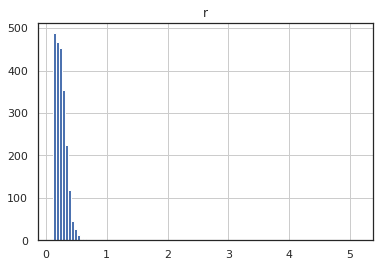

In [66]:
# TODO: plot out x,y,z histograms
#       https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
segments.hist(column='r', bins=100)

#### Bounding box

Below, this bounding box can be used to crop plate images (raw or projections) to the region of interest. The format for the cropbox is how much to crop from each side: ((top, bottom), (left, right))

In [67]:
maxs = segments.max(axis=0)
mins = segments.min(axis=0)

crop_top = mins["y"]
crop_right = maxs["x"]
crop_bottom = maxs["y"]
crop_left = mins["x"]

skeletons_crop_box = ((crop_top, crop_bottom), (crop_left, crop_right))
print(skeletons_crop_box)

((237.7232, 507.4933), (227.65599999999998, 513.3128))


## SWC as 2D images

The Allen Institute has the Allen SDK, which is probably a pretty good reference for parsing their files and loading it into some
First thing to do is what The Allen has in their own SDK docs: [Cell Types examples](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html#Cell-Morphology-Reconstructions). The following code cell is derived from that notebook:




Total number of compartents about to (slowly) plot: 2193


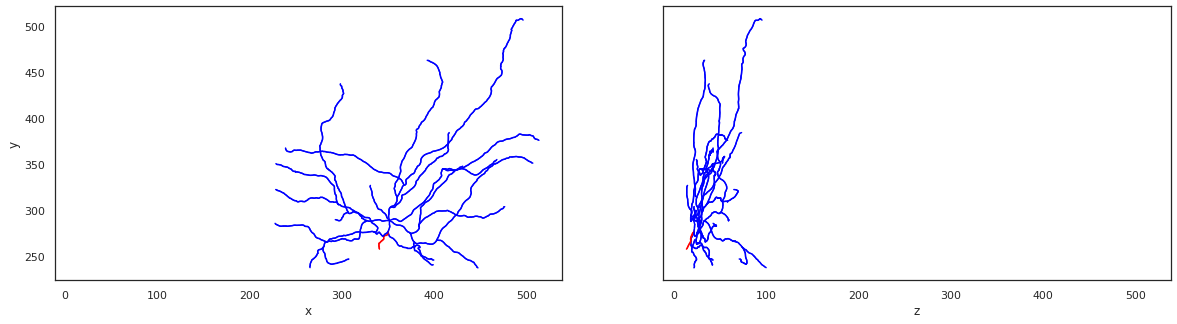

CPU times: user 5.42 s, sys: 61.1 ms, total: 5.48 s
Wall time: 5.48 s


In [68]:
%%time

from allensdk.core.swc import read_swc
from allensdk.core.swc import Marker

# https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/swc.html
morphology = read_swc(swc_file_name)
print("Total number of compartents about to (slowly) plot: %d" % len(morphology.compartment_list))

sns.set(style="white")

fig, axes = plt.subplots(1, 2, figsize=(20,20), sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box') # 'box-forced'

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        if c["type"] == 2:
            skeleton_color = "red"
        else:
            skeleton_color = "blue"
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color=skeleton_color)
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color=skeleton_color)

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
# TODO: legend of blue & red. Title.
plt.show()
pass # suppress <output noise> TODO: not supressing the <Figure size ... message

# TODO: save axex[0] to fileystem, then load in Plotly full screen image viewer for zoom & pan

So, that shows folks how to use `allensdk` to get a SWC file and render it via Python.

Nonetheless, the code rather slow. As is `plot()` is being called on SWC segment at a time. Perhaps there a way to pass arrays to `plot()`?

### Datashader 2D points

CPU times: user 23.3 ms, sys: 2.02 ms, total: 25.3 ms
Wall time: 29.4 ms


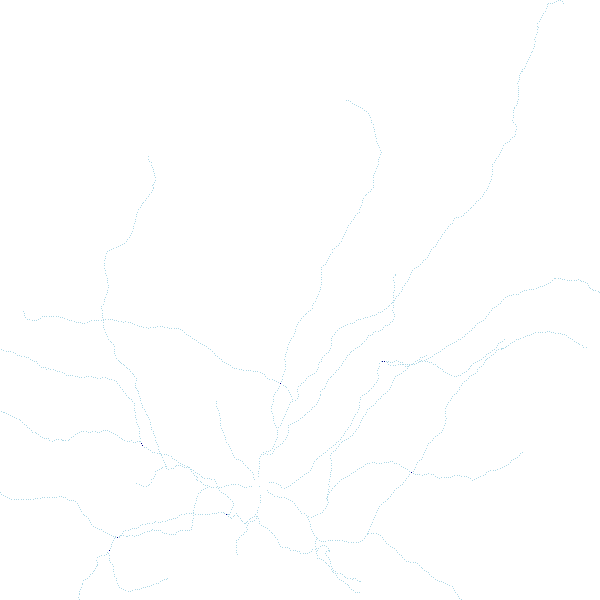

In [69]:
import datashader as ds
import datashader.transfer_functions as tf

%time tf.shade(ds.Canvas().points(segments,'x','y'))


## SWC in 3D

Plotly is a great toolset which works smoothly on Colab. It has some nice 3D capabilities.


#### Point cloud

First quick and dirty thing that can be done is to just 3D plot the (x,y,z) data as points, no line segments between points.



https://plotly.com/python/builtin-colorscales/

OK:
- edge (grayscale-ish)
- phase
- portland
- balance
- bluered


In [70]:
import plotly.express as px
from plotly.colors import sequential
#import plotly.graph_objs as go
#iris = px.data.iris()

fig = px.scatter_3d(segments, x='x', y='y', z='z',
              color='type', size='r', size_max=18,
              opacity=1.0,color_continuous_scale='edge')


# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(plot_bgcolor='#ff0000') #,height=5000, width=5000)


# https://plotly.com/python/3d-axes/
fig.update_layout(coloraxis=dict(showscale=False),
                 scene = dict(
                    xaxis = dict(
                         nticks=1,
                         backgroundcolor="white",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",),
                    yaxis = dict(
                         nticks=1,
                        backgroundcolor="white",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white"),
                    zaxis = dict(
                         nticks=1,
                        backgroundcolor="white",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

Next, naively add line segments between points. That doesn't work so well because the parent-child data is not being used, so long straight line segments jumping between neurite branch ends.

In [71]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

fig = go.Figure(data=[go.Scatter3d(x=segments['x'], y=segments['y'], z=segments['z'],
                                   mode='lines+markers',
                                   marker=dict(size=1, color=0, colorscale='Viridis', opacity=0.8)
                                   )


   ])
fig.show()

#### Streamtubes

This sections is a work in progress. 

Streamtubes are very promising in terms so data model and UI in-browser performance on demo streamtube data. But translating between SWC data model and streamtube data model has not been worked out yet. It might be a bit of a waste and there are other avenues to explore first which might render mute such dev efforts.

[Streamtune API docs](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Streamtube.html)




In [72]:
import plotly
plotly.__version__

'4.4.1'

In [73]:
# Peek inside a CSV, which is the used to drive a basic demo
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-basic.csv')
DataTable(df)

,u,v,w,x,y,z
0,1.000000,1.000000,0.000000,0,0,0
1,1.000000,1.000000,0.088656,0,0,1
2,1.000000,1.000000,0.169393,0,0,2
3,1.000000,0.540302,0.000000,0,1,0
4,1.000000,0.540302,0.088656,0,1,1
5,1.000000,0.540302,0.169393,0,1,2
6,1.000000,-0.416147,0.000000,0,2,0
7,1.000000,-0.416147,0.088656,0,2,1
8,1.000000,-0.416147,0.169393,0,2,2
9,1.841471,1.000000,0.000000,1,0,0


In [74]:
# via https://plotly.com/python/v3/streamtube-plot/#starting-position-and-segments
from plotly.offline import iplot
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-basic.csv')

data = [go.Streamtube(
    x = df['x'],
    y = df['y'],
    z = df['z'],
    u = df['u'],
    v = df['v'],
    w = df['w'],
#    starts = dict(
#        x = [80] * 16,
#        y = [20,30,40,50] * 4,
#        z = [0,0,0,0,5,5,5,5,10,10,10,10,15,15,15,15]
#    ),
    sizeref = 0.3,
    colorscale = 'Portland',
    showscale = False,
    maxdisplayed = 3000
)]

layout = go.Layout(
    scene = dict(
        aspectratio = dict(
            x = 2,
            y = 1,
            z = 0.3
        )
    ),
    margin = dict(
        t = 20,
        b = 20,
        l = 20,
        r = 20
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="streamtube wind")

In [75]:
# https://plotly.com/python/streamtube-plot/

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

x, y, z = np.mgrid[0:10, 0:10, 0:10]
x = x.flatten()
y = y.flatten()
z = z.flatten()

print(y) 

u = np.zeros_like(x)
v = np.zeros_like(y)
w = z**2

fig = make_subplots(rows=1, cols=3, specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d':True}]])

fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=u, v=v, w=w), 1, 1)
fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=w, v=v, w=u), 1, 2)
fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=u, v=w, w=v), 1, 3)

fig.update_layout(scene_camera_eye=dict(x=2, y=2, z=2),
                  scene2_camera_eye=dict(x=2, y=2, z=2),
                  scene3_camera_eye=dict(x=2, y=2, z=2))
fig.show()

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9
 9 9 9 9 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8
 8 8 8 8 8 8 8 8 8 9 9 9 

In [76]:
# https://plotly.com/python/v3/streamtube-plot/#basic-streamtube-plot
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-wind.csv').drop(['Unnamed: 0'],axis=1)

data = [go.Streamtube(
    x = df['x'],
    y = df['y'],
    z = df['z'],
    u = df['u'],
    v = df['v'],
    w = df['w'],
    starts = dict(
        x = [80] * 16,
        y = [20,30,40,50] * 4,
        z = [0,0,0,0,5,5,5,5,10,10,10,10,15,15,15,15]
    ),
    sizeref = 0.3,
    colorscale = 'Portland',
    showscale = False,
    maxdisplayed = 3000
)]

layout = go.Layout(
    scene = dict(
        aspectratio = dict(
            x = 2,
            y = 1,
            z = 0.3
        )
    ),
    margin = dict(
        t = 20,
        b = 20,
        l = 20,
        r = 20
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="streamtube wind")

## Appendices

### Tests

The idea here is to have a very simple test harness for running tests on code from within this notebook. And the same tests should work if the code in this `*.ipynb` is exported to `*.py`.
 